# **Neutrino Oscillation with DUNE**

## PHYS591000 Physics AI Final Project

This is the project implementing ML to find out the $\Theta_{13}$ and $\delta_{cp}$ using the neutrino data from DUNE experiment.  
Original link: [Kaggle](https://www.kaggle.com/competitions/phys591000-2023-final-project-i)

> Author(s): Siang-Yuan Lin, Yuan-Yen Peng  
> Email(s) : sylin@gapp.nthu.edu.tw, garyphys0915@gapp.nthu.edu.tw  
> Licence : MIT  
> Data : May, 2023


### prerequisites

1. reset all varialbes
2. import curcial modules
3. mount google drive
4. check the GPU is on


In [1]:
# clear all variables
%reset -f 

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from numba import njit  # acceleration kernel
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# # mount the google drive to retrieve dataset

# from google.colab import drive

# drive.mount('/content/drive')

In [4]:
# check the tensorflow and GPU

print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


Using Tensorflow 2.11.0
Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### import datasets

1. check files exist
2. retrieve data
3. check shapes of data


In [5]:
# import the datasets and check the files

import os

# path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
path = "/kaggle/input/phys591000-2023-final-project-i/"# Kaggle
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print("-> The file is", filename)
if not os.path.isfile(path + "neutrino_test_data.npz") or os.path.isfile(
    path + "neutrino_train_data.npz"
):
    raise FileNotFoundError("test/train data was not found or is a directory")


/kaggle/input/phys591000-2023-final-project-i/prediction_template.csv
-> The file is prediction_template.csv
/kaggle/input/phys591000-2023-final-project-i/neutrino_training_data.npz
-> The file is neutrino_training_data.npz
/kaggle/input/phys591000-2023-final-project-i/neutrino_test_data.npz
-> The file is neutrino_test_data.npz


In [6]:
%%time
# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
name_test = data_test.files

print(f"Train: {name_train}")
print(f"Test : {name_test}")

ve_train, vebar_train, vu_train, vubar_train, theta23_train, delta_train, ldm_train = map(lambda n: data_train[n], name_train)
ve_test, vebar_test, vu_test, vubar_test = map(lambda n: data_test[n], name_test)

Train: ['ve', 'vebar', 'vu', 'vubar', 'theta23', 'delta', 'ldm']
Test : ['ve', 'vebar', 'vu', 'vubar']
CPU times: user 11.3 s, sys: 867 ms, total: 12.2 s
Wall time: 20 s


In [7]:
# check the data shape

print(
    f"""# TRAIN
ve_train     :{ve_train.shape}
vebar_train  :{vebar_train.shape}
vu_train     :{vu_train.shape}
vubar_train  :{vubar_train.shape}
theta23_train:{theta23_train.shape}
delta_train  :{delta_train.shape}
ldm_train    :{ldm_train.shape}
"""
)
print(
    f"""# TEST
ve_test      :{ve_test.shape}
vebar_test   :{vebar_test.shape}
vu_test      :{vu_test.shape}
vubar_test   :{vubar_test.shape}
"""
)


# TRAIN
ve_train     :(1000000, 65)
vebar_train  :(1000000, 65)
vu_train     :(1000000, 65)
vubar_train  :(1000000, 65)
theta23_train:(1000000,)
delta_train  :(1000000,)
ldm_train    :(1000000,)

# TEST
ve_test      :(1000, 65)
vebar_test   :(1000, 65)
vu_test      :(1000, 65)
vubar_test   :(1000, 65)



### preprocessing

1. create train and test data
2. inspect data structure
3. check data
4. normalize data
5. <pending>


In [8]:
# create train and test data
X_train = np.stack((ve_train, vebar_train, vu_train, vubar_train), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

print(
    f"""
The shape of x_train: {X_train.shape}
The shape of y_train: {Y_train.shape}
The shape of x_test : {X_test.shape}
"""
)



The shape of x_train: (1000000, 65, 4)
The shape of y_train: (1000000, 3)
The shape of x_test : (1000, 65, 4)



In [9]:
# define plotting functions


def four_plot(data_format: list) -> None:
    train, test = data_format
    bins = np.arange(0.625, 8 + 0.125, 0.125)
    name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=80, constrained_layout=True)
    fig.suptitle("First 60 features")
    for i, (train_data, test_data, name) in enumerate(zip(train, test, name)):
        ax = axes[i // 2, i % 2]
        ax.set_title(name)
        ax.step(bins, train_data[:60], label="train")
        ax.step(bins, test_data[:60], label="test")
        ax.legend(loc="best")
        ax.set_xlabel("Energy E [GeV]")
        ax.set_ylabel(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")

    plt.show()
    print("Success to plot")
    plt.close()
    return


def four_2d_plot(data_format: list) -> None:
    name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]
    vmin = min(np.min(data_format[0]), np.min(data_format[1]))
    vmax = max(np.max(data_format[0]), np.max(data_format[1]))
    dataset_name = ["train", "test"]
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=80, constrained_layout=True)
    fig.suptitle("First 60 features")
    for i, data in enumerate(data_format):
        ax = axes[i]
        im = ax.imshow(data.T, origin="lower")
        ax.set_title(dataset_name[i])
        ax.set_xlabel("Energy E [GeV]")
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(name)
        im.set_clim(vmin, vmax)
    cbar = fig.colorbar(im, ax=axes, location="bottom", aspect=25, pad=0.1)
    cbar.ax.set_title(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")
    plt.show()
    print("Success to plot")
    plt.close()
    return


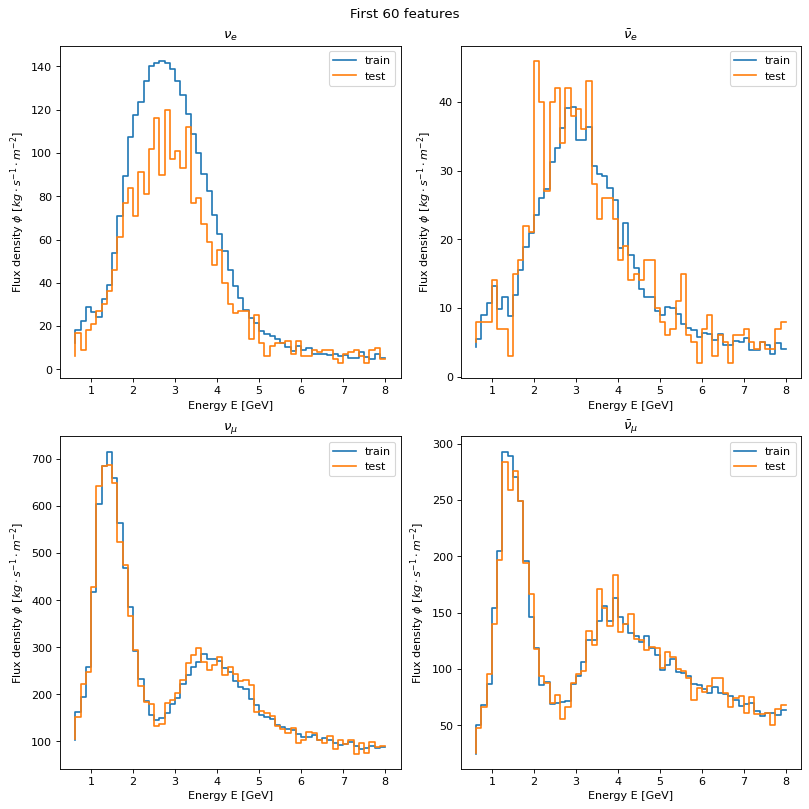

Success to plot


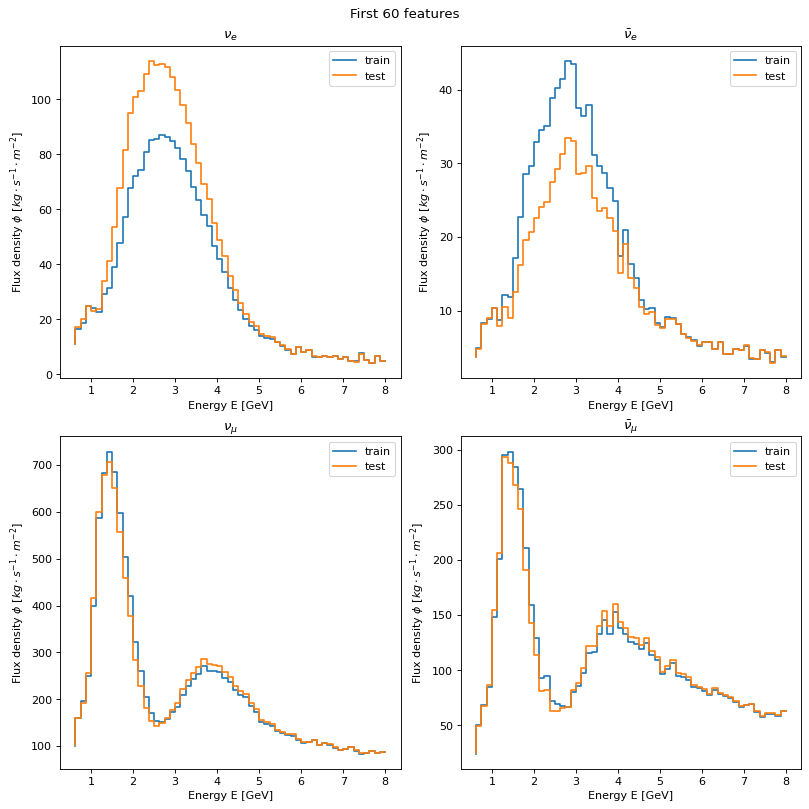

Success to plot


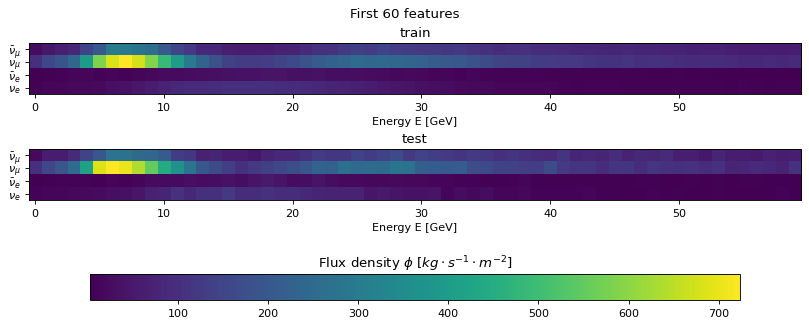

Success to plot


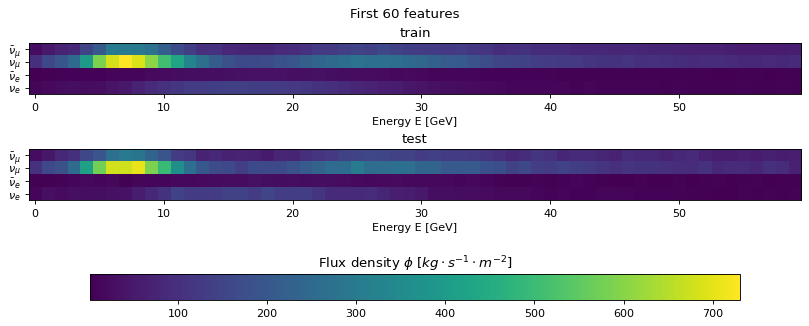

Success to plot


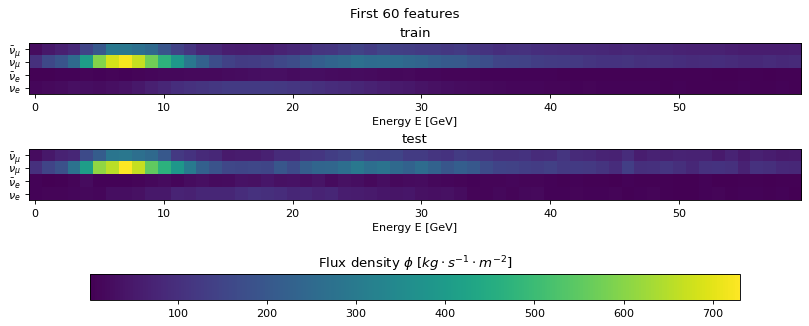

Success to plot


In [10]:
# inspect data structures

# check ``1D images''
train_10 = [ve_train[10], vebar_train[10], vu_train[10], vubar_train[10]]
test_10 = [ve_test[10], vebar_test[10], vu_test[10], vubar_test[10]]
train_average = [
    np.average(ve_train, axis=0),
    np.average(vebar_train, axis=0),
    np.average(vu_train, axis=0),
    np.average(vubar_train, axis=0),
]
test_average = [
    np.average(ve_test, axis=0),
    np.average(vebar_test, axis=0),
    np.average(vu_test, axis=0),
    np.average(vubar_test, axis=0),
]
data_format = [train_10, test_10]
data_sum_format = [train_average, test_average]
four_plot(data_format)
four_plot(data_sum_format)

# check ``2D images''
for i in [9, 99, 999]:
    data_format = [X_train[i, 0:60, :], X_test[i, 0:60, :]]
    four_2d_plot(data_format)


The max of $\Theta_{13}$ [rad] is 51.1;
The min of $\Theta_{13}$ [rad] is 38.9;
The avg of $\Theta_{13}$ [rad] is 45.002699455700025.

The max of $\delta_{cp}$ [rad] is 360.0;
The min of $\delta_{cp}$ [rad] is 8.54954e-05;
The avg of $\delta_{cp}$ [rad] is 180.1832076771041.



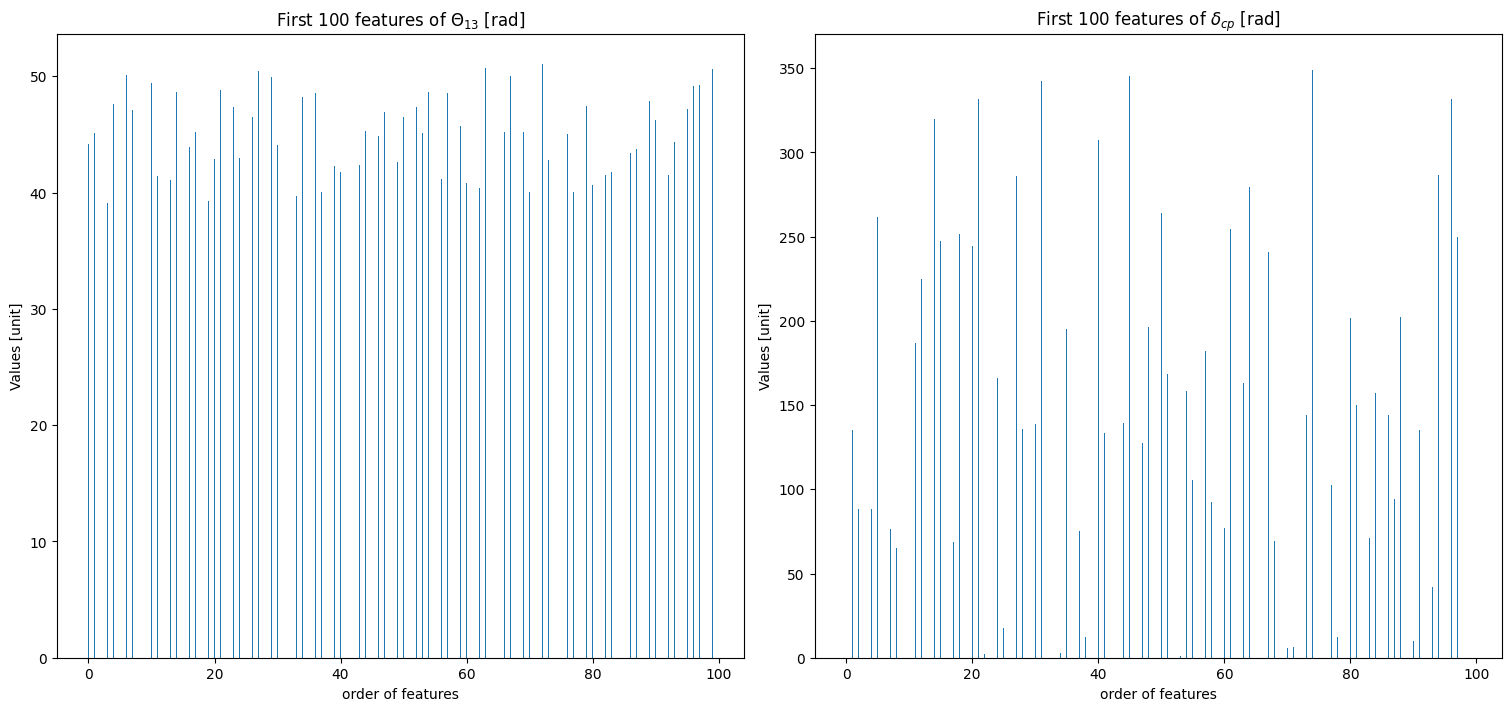

In [11]:
# check theta and delta relations

fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=100, constrained_layout=True)
for i, name in enumerate([r"$\Theta_{13}$ [rad]", r"$\delta_{cp}$ [rad]"]):
    print(
        f"""The max of {name} is {np.max(Y_train[:, i])};
The min of {name} is {np.min(Y_train[:, i])};
The avg of {name} is {np.average(Y_train[:, i])}.
"""
    )
    ax = axes[i]
    n = 100
    ax.bar(np.arange(n), Y_train[:n, i], width=0.1)
    ax.set_title(f"First 100 features of {name}")
    ax.set_xlabel("order of features")
    ax.set_ylabel("Values [unit]")
plt.show()
plt.close()


In [13]:
train_normal = X_train[ldm_train > 0]
train_invert = X_train[ldm_train < 0]
theta23_normal = theta23_train[ldm_train > 0]
theta23_invert = theta23_train[ldm_train < 0]
delta_normal = delta_train[ldm_train > 0]
delta_invert = delta_train[ldm_train < 0]

def norm_alg(input_data):
    data_max = np.max(input_data,axis = 0)
    offset = np.min(input_data,axis = 0)
    scale = data_max - offset
    input_data  = (input_data-offset)/scale
    return input_data

#normalize labels to [0,1]
ldm_train_norm = norm_alg(ldm_train)
theta23_NH_norm = norm_alg(theta23_normal)
theta23_IH_norm = norm_alg(theta23_invert)
delta_NH_norm = norm_alg(delta_normal)
delta_IH_norm = norm_alg(delta_invert)

#normalize training data to [0,1]
v_max = np.max(X_train)
v_min = np.min(X_train)
train_NH_norm = (train_normal - v_min)/(v_max- v_min)
train_IH_norm = (train_invert- v_min)/(v_max- v_min)
labeling = np.where(ldm_train > 0, 1, 0)

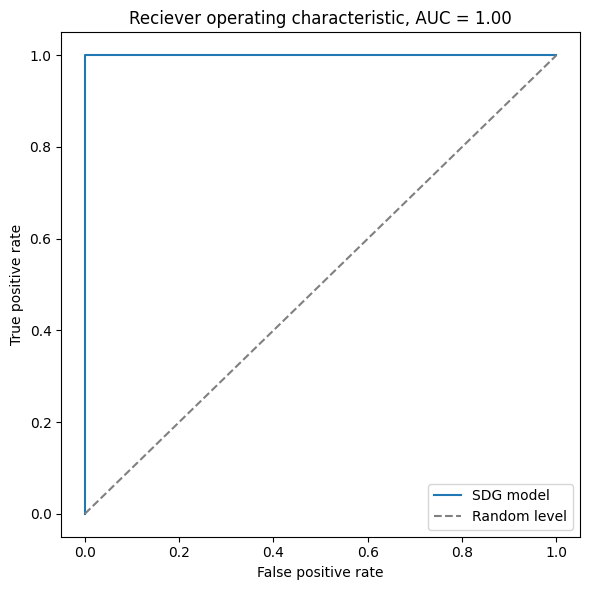

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

ldm_class = SGDClassifier(max_iter=1000, tol=1e-3)
ldm_class.fit(X_train[:,:,0],labeling)
train_predict = ldm_class.predict(X_train[:,:,0])

fpr, tpr, thresholds = metrics.roc_curve(labeling, train_predict, pos_label=1)
plt.figure(figsize = (6,6))
plt.plot(fpr,tpr, label = 'SDG model')
plt.plot([0,1],[0,1],label = 'Random level',ls = 'dashed',c = 'Grey')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("Reciever operating characteristic, AUC = {:.2f}".format(metrics.auc(fpr,tpr)))
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

### model


In [15]:
# create validation data
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2
tf.random.set_seed(2023)
x_train, x_val, y_train, y_val = train_test_split(X_train[train_predict == 1], Y_train[:, 0:2][train_predict == 1], test_size=0.2, shuffle=True)
x_test = X_test
print(
    f"""
The shape of x_train     : {x_train.shape}
The shape of y_train     : {y_train.shape}
The shape of x_validation: {x_val.shape}
The shape of y_validation: {y_val.shape}
The shape of x_test      : {x_test.shape}
"""
)


The shape of x_train     : (400021, 65, 4)
The shape of y_train     : (400021, 2)
The shape of x_validation: (100006, 65, 4)
The shape of y_validation: (100006, 2)
The shape of x_test      : (1000, 65, 4)



#### CVAE

In [16]:
# Define sample_z function

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

def sample_z(inputs: list):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class KLDivergenceLayer(Layer):

    """Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [17]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Reshape,
    Conv2D,
    AveragePooling2D,
    Conv2DTranspose,
    LeakyReLU,
    Flatten,
    Dense,
    Lambda,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K


def conv2d(inputs, filters, kernel_size):
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    return x


def deconv2d(inputs, filters, kernel_size):
    x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(1, kernel_size=kernel_size, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    return x


def create_model_cvae(input_dim, latent_dim):
    # Encoder
    encoder_inputs = Input(shape=input_dim)
    x = conv2d(encoder_inputs, filters=64, kernel_size=4)
    x = conv2d(x, filters=32, kernel_size=4)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(latent_dim)(x)
    z_mu = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z = Lambda(sample_z, output_shape=(latent_dim,))([z_mu, z_log_var])
    encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
    encoder.summary()

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(128)(latent_inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((4, 4, 16))(x)
    x = deconv2d(x, filters=64, kernel_size=4)
    x = Reshape((8, 8, 1))(x)
    x = deconv2d(x, filters=32, kernel_size=4)
    x = Dense(np.prod(input_dim))(x)
    x = LeakyReLU(alpha=0.2)(x)
    decoder = Model(latent_inputs, x, name="decoder")
    decoder.summary()

    # DNN (conti --> decoder)
    inputs = Input(shape=x.shape)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(0.001))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation="linear")(x)
    dnn = Model(inputs, x, name="dnn")
    dnn.summary()

    # CVAE + DNN
    autoencoder_input = Input(shape=input_dim)
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded[2])
    fin_dnn = dnn(decoded)
    cvae = Model(inputs=autoencoder_input, outputs=fin_dnn)
    return cvae


In [18]:
from tensorflow.keras.optimizers import Adam

# Declare the model
cvae = create_model_cvae(
    input_dim=(x_train.shape[1], x_train.shape[2], 1), latent_dim=2
)

# Compile the model
cvae.compile(optimizer=Adam(1e-5), loss="mse")

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 4, 1)]   0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 65, 4, 64)    1088        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 65, 4, 64)   256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 65, 4, 64)    0           ['batch_normalization_2[0][

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# train
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=30,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

cvae.fit(
    x=x_train,
    y=y_train[:, 0],
    validation_data=(x_val, y_val[:, 0]),
    epochs=256,
    batch_size=128,
    callbacks=[early_stopping],
    shuffle=True,
    verbose=2,
)

782/782 - 13s - loss: 705.6788 - val_loss: 175.5482 - 13s/epoch - 17ms/step


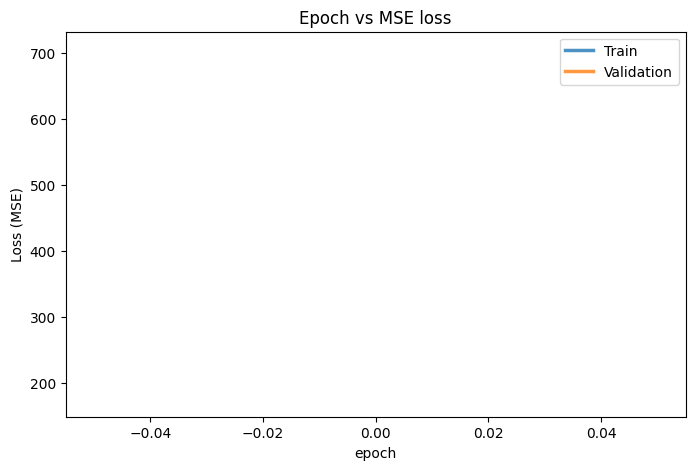

In [21]:
fig = plt.figure(figsize=(8, 5), dpi=100)
history = cvae.history.history
plt.plot(history["loss"], lw=2.5, label="Train", alpha=0.8)
plt.plot(history["val_loss"], lw=2.5, label="Validation", alpha=0.8)
plt.title("Epoch vs MSE loss")
plt.xlabel("epoch")
plt.ylabel("Loss (MSE)")
plt.legend(loc="best")
plt.show()
plt.close()

In [ ]:
# predict

x_train_pred = cvae.predict(x_train)
x_test_pred  = cvae.predict(x_test)

In [ ]:
# statistical parameters
n = len(x_train_pred[:,0])
dof = n - 2
t = scipy.stats.t.ppf(0.975, dof)

# linear fitting line
slope, intercept, r, p, se = scipy.stats.linregress(x_train_pred[:,0], y_train[:,0])
plt_min = np.min([np.min(x_train_pred), np.min(y_train[:,0])])
plt_max = np.max([np.max(x_train_pred), np.max(y_train[:,0])])
x_line = np.linspace(plt_min, plt_max, 100)
y_line = np.polyval([slope, intercept], x_line)

# acceleration kernel (to calculate mse, confident level, and prediction level)
@njit(fastmath=True)
def mse_kernel(pred, true, t_value=t, n=n, dof=dof, x_line=x_line, y_line=y_line):
    if true.shape != pred.shape:
        raise ValueError("True/Pred data should be the same shape!") 
    mse = np.empty(len(true))
    for ind, (t, p) in enumerate(zip(true, pred)):
        mse[ind] = np.average(np.square(t - p))
    pred_mean = np.average(x_train_pred[:,0])
    sum_se = np.sum(np.square(true - pred))
    std_error = np.sqrt(1/dof * sum_se)
    # confidence interval
    ci = t_value * std_error * np.sqrt(1/n + np.square(x_line - pred_mean)/np.sum(np.square(x_train_pred[:,0] - pred_mean)))
    # predicting interval
    pi = t_value * std_error * np.sqrt(1 + 1/n + np.square(x_line - pred_mean)/np.sum(np.square(x_train_pred[:,0] - pred_mean)))
    return mse, ci, pi

mse, ci, pi = mse_kernel(x_train_pred[:,0], y_train[:,0])

In [ ]:
fig = plt.figure(figsize=(7,7), dpi=80)
plt.scatter(x_train_pred, y_train[:,0], s=3, alpha=.05, label="data")
plt.plot(x_line, y_line, '--', lw=2, c='red')
plt.plot([plt_min, plt_max], [plt_min, plt_max], '-', lw=1, c='orange', label="theo line")
plt.plot(x_line, y_line + pi, '--', lw=1, c='tab:red', label='95% prediction interval')
plt.plot(x_line, y_line - pi, '--', lw=1, c='tab:red')
# plt.plot(x_line, y_line + ci, '--', c='tab:grey', label='95% confidence interval')
# plt.plot(x_line, y_line - ci, '--', c='tab:grey')
plt.xlim(plt_min, plt_max)
plt.ylim(plt_min, plt_max)
plt.legend(loc='best')
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()

plt.title(r"$\Theta_{13}$")
plt.xlabel("Train loss (MSE)")
plt.hist(mse, bins=50, density=False, alpha=.8, color='tab:blue', label='bkg')
plt.legend(loc='best')
plt.show()

#### DVAE

In [ ]:
def create_model_dvae(input_dim, latent_dim):
    # Define sample_z function

    def sample_z(inputs: list):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    class KLDivergenceLayer(Layer):

        """Identity transform layer that adds KL divergence
        to the final model loss.
        """

        def __init__(self, *args, **kwargs):
            self.is_placeholder = True
            super(KLDivergenceLayer, self).__init__(*args, **kwargs)

        def call(self, inputs):
            mu, log_var = inputs
            kl_batch = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
            self.add_loss(K.mean(kl_batch), inputs=inputs)

            return inputs
    
    # Encoder
    encoder_inputs = Input(shape=input_dim)
    x = Flatten()(encoder_inputs)
    x = Dense(np.prod(input_dim))(x)
    x = Dense(128, activation='elu')(x)
    x = Dense(64, activation='elu')(x)
    x = Dense(16, activation='elu')(x)
    x = Dense(latent_dim, activation='elu')(x)
    z_mu = Dense(latent_dim, activation='elu')(x)
    z_log_var = Dense(latent_dim, activation='elu')(x)
    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z = Lambda(sample_z, output_shape=(latent_dim,))([z_mu, z_log_var])
    encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
    encoder.summary()

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(8, activation='elu')(latent_inputs)
    x = Dense(16, activation='elu')(x)
    x = Dense(64, activation='elu')(x)
    x = Dense(128, activation='elu')(x)
    x = Dense(np.prod(input_dim))(x)
    decoder = Model(latent_inputs, x, name="decoder")
    decoder.summary()

    # DNN (conti --> decoder)
    inputs = Input(shape=x.shape)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='elu')(inputs)
    x = Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='elu')(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='elu')(x)
    x = Dense(1, activation="linear")(x)
    dnn = Model(inputs, x, name="dnn")
    dnn.summary()

    # DVAE + DNN
    autoencoder_input = Input(shape=input_dim)
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded[2])
    fin_dnn = dnn(decoded)
    dvae = Model(inputs=autoencoder_input, outputs=fin_dnn)
    return dvae


In [ ]:
# Declare the model
dvae = create_model_dvae(
    input_dim=(x_train.shape[1], x_train.shape[2]), latent_dim=2
)

# Compile the model
dvae.compile(optimizer=Adam(1e-5), loss="mse")

In [ ]:
fig = plt.figure(figsize=(8, 5), dpi=100)
history = dvae.history.history
plt.plot(history["loss"], lw=2.5, label="Train", alpha=0.8)
plt.plot(history["val_loss"], lw=2.5, label="Validation", alpha=0.8)
plt.title("Epoch vs MSE loss")
plt.xlabel("epoch")
plt.ylabel("Loss (MSE)")
plt.legend(loc="best")
plt.show()

In [ ]:
# predict

x_train_pred = dvae.predict(x_train)
x_test_pred  = dvae.predict(x_test)

In [ ]:
# statistical parameters
n = len(x_train_pred[:,0])
dof = n - 2
t = scipy.stats.t.ppf(0.975, dof)

# linear fitting line
slope, intercept, r, p, se = scipy.stats.linregress(x_train_pred[:,0], y_train[:,0])
plt_min = np.min([np.min(x_train_pred), np.min(y_train[:,0])])
plt_max = np.max([np.max(x_train_pred), np.max(y_train[:,0])])
x_line = np.linspace(plt_min, plt_max, 100)
y_line = np.polyval([slope, intercept], x_line)

# acceleration kernel (to calculate mse, confident level, and prediction level)
@njit(fastmath=True)
def mse_kernel(pred, true, t_value=t, n=n, dof=dof, x_line=x_line, y_line=y_line):
    if true.shape != pred.shape:
        raise ValueError("True/Pred data should be the same shape!") 
    mse = np.empty(len(true))
    for ind, (t, p) in enumerate(zip(true, pred)):
        mse[ind] = np.average(np.square(t - p))
    pred_mean = np.average(x_train_pred[:,0])
    sum_se = np.sum(np.square(true - pred))
    std_error = np.sqrt(1/dof * sum_se)
    # confidence interval
    ci = t_value * std_error * np.sqrt(1/n + np.square(x_line - pred_mean)/np.sum(np.square(x_train_pred[:,0] - pred_mean)))
    # predicting interval
    pi = t_value * std_error * np.sqrt(1 + 1/n + np.square(x_line - pred_mean)/np.sum(np.square(x_train_pred[:,0] - pred_mean)))
    return mse, ci, pi

mse, ci, pi = mse_kernel(x_train_pred[:,0], y_train[:,0])

In [ ]:
fig = plt.figure(figsize=(7,7), dpi=80)
plt.scatter(x_train_pred, y_train[:,0], s=3, alpha=.05, label="data")
plt.plot(x_line, y_line, '--', lw=2, c='red')
plt.plot([plt_min, plt_max], [plt_min, plt_max], '-', lw=1, c='orange', label="theo line")
plt.plot(x_line, y_line + pi, '--', lw=1, c='tab:red', label='95% prediction interval')
plt.plot(x_line, y_line - pi, '--', lw=1, c='tab:red')
# plt.plot(x_line, y_line + ci, '--', c='tab:grey', label='95% confidence interval')
# plt.plot(x_line, y_line - ci, '--', c='tab:grey')
plt.xlim(plt_min, plt_max)
plt.ylim(plt_min, plt_max)
plt.legend(loc='best')
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()

plt.title(r"$\Theta_{13}$")
plt.xlabel("Train loss (MSE)")
plt.hist(mse, bins=50, density=False, alpha=.8, color='tab:blue', label='bkg')
plt.legend(loc='best')
plt.show()

### dump the predicted data


In [ ]:
# # dump the predicted data
# """
# 0 for qcd; 1 for wprime
# """

# pred_label = [0 if i < cut else 1 for i in new_loss_data]
# np.savetxt("submission.csv", [('id', 'prediction')] + [(i, j) for i, j in enumerate(pred_label)], delimiter=",", fmt='%s')
